# IAU Project - Classification

**Authors:** Peter Mačinec, Lukáš Janík

## Setup and import libraries

At first, we need to import libraries and our pipeline classes from preprocessing:

In [116]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce

from sklearn import model_selection as ms

# pipelines
from sklearn.pipeline import Pipeline

# custom pipelines
import pipelines
from pipelines import MergeRemoveDuplicates
from pipelines import DropRowsNanColumn
from pipelines import NanUnifier
from pipelines import BooleanUnifier
from pipelines import WordsUnifier
from pipelines import DateFormatUnifier
from pipelines import ClassUnifier
from pipelines import DropColumn
from pipelines import ColumnExpander
from pipelines import ColumnToNumber
from pipelines import MeasuredValuesFixer
from pipelines import Normalizer
from pipelines import OutliersRemover
from pipelines import OutliersReplacer
from pipelines import NumMedianFiller
from pipelines import NumModelFiller
from pipelines import CategoricalMostFrequentFiller
from pipelines import CategoricalModelFiller
from pipelines import ColumnsSelector
from pipelines import ColumnsEncoder

# hiding warnings for better appereance (this was added after checking all warnings)
import warnings
warnings.filterwarnings(action='ignore')

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# model evaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# oversampling
#from imblearn.over_sampling import RandomOverSampler, SMOTE

pd.options.mode.chained_assignment = None  # default='warn'

## Data loading

At first, we need to load all datasets. *Train* and *valid* datasets will be used for training and evaluating model, *test* dataset will be just predicted.

In [2]:
# read datasets
df1_train = pd.read_csv('data/personal_train.csv', index_col=0)
df2_train = pd.read_csv('data/other_train.csv', index_col=0)

df1_test = pd.read_csv('data/personal_test.csv', index_col=0)
df2_test = pd.read_csv('data/other_test.csv', index_col=0)

df1_valid = pd.read_csv('data/personal_valid.csv', index_col=0)
df2_valid = pd.read_csv('data/other_valid.csv', index_col=0)

### Merge datasets

We need to merge both datasets into one. In previous analysis, we found that name and address would be used for merging:

In [67]:
df_train_raw = pd.merge(df1_train, df2_train, on=["name", "address"])
df_test_raw = pd.merge(df1_test, df2_test, on=["name", "address"])
df_valid_raw = pd.merge(df1_valid, df2_valid, on=["name", "address"])

## Preprocessing

Before data will be used for classification, we must preprocess them. Preprocessing pipeline custom classes were imported from *pipelines.py* file.

Because only *train* and *valid* datasets contain *class* attribute, *ClassUnifier* will be applied separately. Let's create both pipelines:

In [4]:
ppl = Pipeline([
                # Data repairing
                # ======================
                # unify boolean values
                ('unify_boolean', BooleanUnifier(['query hyperthyroid', 'T4U measured', 'on thyroxine', 'FTI measured', 'lithium', 'TT4 measured',
                                                  'query hypothyroid', 'query on thyroxine', 'tumor', 'T3 measured', 'sick', 'thyroid surgery', 
                                                  'I131 treatment', 'goitre', 'TSH measured', 'on antithyroid medication', 'psych', 'TBG measured',
                                                  'pregnant', 'hypopituitary'])),

                # unify date format
                ('date_unifier', DateFormatUnifier('date_of_birth')),

                # drop column
                ('drop_TBG_measured', DropColumn('TBG measured')),
                ('drop_TBG', DropColumn('TBG')),

                # measured columns fix
                ('fix_measured_values',MeasuredValuesFixer(['T4U', 'FTI', 'TT4', 'TT4','TSH','T3'])),

                # expand column
                ('expand_personal_info', ColumnExpander()),

                # unify nan values
                ('nan_unify_FTI', NanUnifier(['FTI', 'sex', 'origin', 'occupation'])),

                # transform data type
                ('column_to_number_FTI', ColumnToNumber('FTI')),

                # merge and remove duplicates
                ('rm_duplicates', MergeRemoveDuplicates()),
                
                # ======================

                # Data normalization
                # ======================
                ('norm_numerical', Normalizer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Outliers replacement
                # ======================
                ('reout_numerical', OutliersReplacer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Filling numerical values by Linear Regression
                # ======================
                ('flr_T4U', NumModelFiller('T4U', LinearRegression())),
                ('flr_TT4', NumModelFiller('TT4', LinearRegression())),
                ('flr_T3', NumModelFiller('T3', LinearRegression())),
                ('flr_TSH', NumModelFiller('TSH', LinearRegression())),
                ('flr_FTI', NumModelFiller('FTI', LinearRegression())),
                ('flr_age', NumModelFiller('age', LinearRegression())),
                ('flr_education_num', NumModelFiller('education-num', LinearRegression())),
                ('flr_fnlwgt', NumModelFiller('fnlwgt', LinearRegression())),
                ('flr_capital_loss', NumModelFiller('capital-loss', LinearRegression())),
                ('flr_capital_gain', NumModelFiller('capital-gain', LinearRegression())),
                ('flr_hours_per_week', NumModelFiller('hours-per-week', LinearRegression())),
                # ======================

                # Filling categorical values by RF
                # ======================
                ('fill_rf_sex', CategoricalModelFiller('sex', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_pregnant', CategoricalModelFiller('pregnant', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_tumor', CategoricalModelFiller('tumor', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_occupation', CategoricalModelFiller('occupation', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_origin', CategoricalModelFiller('origin', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_query_hypothyroid', CategoricalModelFiller('query hypothyroid', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_query_hyperthyroid', CategoricalModelFiller('query hyperthyroid', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_on_thyroxine', CategoricalModelFiller('on thyroxine', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_sick', CategoricalModelFiller('sick', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_thyroid_surgery', CategoricalModelFiller('thyroid surgery', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_workclass', CategoricalModelFiller('workclass', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_I131_treatment', CategoricalModelFiller('I131 treatment', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_hypopituitary', CategoricalModelFiller('hypopituitary', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_query_on_thyroxine', CategoricalModelFiller('query on thyroxine', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_on_antithyroid_medication', CategoricalModelFiller('on antithyroid medication', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_referral_source', CategoricalModelFiller('referral source', RandomForestClassifier(n_estimators=100, max_depth=7))),
                ('fill_rf_psych', CategoricalModelFiller('psych', RandomForestClassifier(n_estimators=100, max_depth=7))),
                # Filling categorical with most frequent value
                # ======================
                ('fill_mf_date_of_birth', CategoricalMostFrequentFiller(['date_of_birth'])),
                ('fill_mf_study', CategoricalMostFrequentFiller(['study'])),
                ('fill_mf_status1', CategoricalMostFrequentFiller(['status1'])),
                ('fill_mf_status2', CategoricalMostFrequentFiller(['status2']))
              ])

ppl_class_unifier = Pipeline([
        ('class_unifier', ClassUnifier())
    ])

Created pipelines can be now used to preprocess our data. Pipeline with *ClassUnifier* will not be applied to *test* dataframe as mentioned before. 

In [5]:
df_train = ppl.fit_transform(df_train_raw)
df_valid = ppl.transform(df_valid_raw)

df_train = ppl_class_unifier.fit_transform(df_train)
df_valid = ppl_class_unifier.transform(df_valid)

df_test = ppl.transform(df_test_raw)

Score for column T4U: -0.00375249754477
Score for column TT4: -0.00446104387472
Score for column T3: -0.0792112648518


Score for column TSH: -1.87534953942
Score for column FTI: -0.00379473904915
Score for column age: -0.166944935628


Score for column education-num: -0.684583668241
Score for column fnlwgt: -10951708199.6


Score for column capital-loss: -133567.455703
Score for column capital-gain: -62578167.4816
Score for column hours-per-week: -145.492377095


Score for column sex: 0.71567587964


Score for column pregnant: 0.986568232492


Score for column tumor: 0.975868513773


Score for column occupation: 0.278460034086


/ext/sage/sage-8.4_1804/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Score for column origin: 0.883912474487


Score for column query hypothyroid: 0.87149013275


Score for column query hyperthyroid: 0.874184968681


Score for column on thyroxine: 0.882439684319


Score for column sick: 0.917614910314


Score for column thyroid surgery: 0.986144627732


Score for column workclass: 0.715323562622


Score for column I131 treatment: 0.921580646309


Score for column hypopituitary: 1.0


Score for column query on thyroxine: 0.922911995516


Score for column on antithyroid medication: 0.98793441704


Score for column referral source: 0.639247611936


Score for column psych: 0.951277045784


Our dataframes are now preprocessed. We can check scores for predictions of filling values.

Let's check how data look like after preprocessing:

In [6]:
df_train.head()

,index,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,...,education-num,psych,occupation,pregnant,bred,origin,study,status1,status2,class_status
0,0,Terry Terry,"11818 Lori Crossing Apt. 802\r\nPughstad, DC 7...",4.143135,M,12/09/1955,False,False,False,False,...,2.197225,False,Transport-moving,False,white,united-states,hs-grad,divorced,unmarried,negative
1,1,Edith Boudreaux,"PSC 4657, Box 5446\r\nAPO AP 58412",4.290459,F,30/04/1945,False,True,True,False,...,2.453098,False,Prof-specialty,False,white,united-states,bachelors,never-married,own-child,negative
2,2,Janet Washington,Unit 9759 Box 9470\r\nDPO AP 45549,4.304065,F,06/06/1944,False,True,True,False,...,2.536116,False,Craft-repair,False,white,united-states,hs_grad,divorced,unmarried,negative
3,3,Margaret Chabot,"137 Lewis Flat Suite 762\r\nWest Elizabeth, AL...",3.891820,F,01/10/1969,False,True,True,False,...,2.302585,False,Adm-clerical,False,white,united-states,some-college,divorced,unmarried,negative
4,4,Colleen Satterwhite,"995 Frank Stravenue\r\nSouth Matthewport, TX 8...",2.995732,F,08/01/2016,False,True,True,False,...,2.197225,False,Other-service,False,black,united-states,hs-grad,never-married,unmarried,negative


Similarly, valid and test datasets have been preprocessed.

## Choosing columns and encoding values

Last step before data are ready for classification is to choose columns and encode categorical values. For this purpose, OneHotEncoding will be used. 

Saving our labels into separate variables is important for fitting classifiers:

In [9]:
y_train = df_train['class_status']
y_test = df_valid['class_status']

Let's select columns and encode categorical attributes:

In [10]:
ppl_select_encode = Pipeline([
                        ('col_select', ColumnsSelector(['T4U', 'TT4', 'TSH', 'T3', 'FTI', 'sex', 'pregnant', 'origin'])),
                        ('cat_encode', ColumnsEncoder(['sex', 'pregnant', 'origin']))
                    ])

In [11]:
X_train = ppl_select_encode.fit_transform(df_train)
X_test = ppl_select_encode.transform(df_valid)

Because our data are heavily unbalanced, we will try **oversampling**. 2 methods of oversampling will be tried, *random* and *SMOTE* from imbalanced learn library (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html).

In [0]:
X_res_rand, y_res_rand = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
X_res_smote, y_res_smote = SMOTE(random_state=0).fit_resample(X_train, y_train)

## Classification

At this section, we will try to classify **class**, that indicate whether is patient ill or not, with preprocessed data.

### Classification rules

At first, we will try to choose classification rules manually, depending on previous analysis. For recapitulation, let's check plots

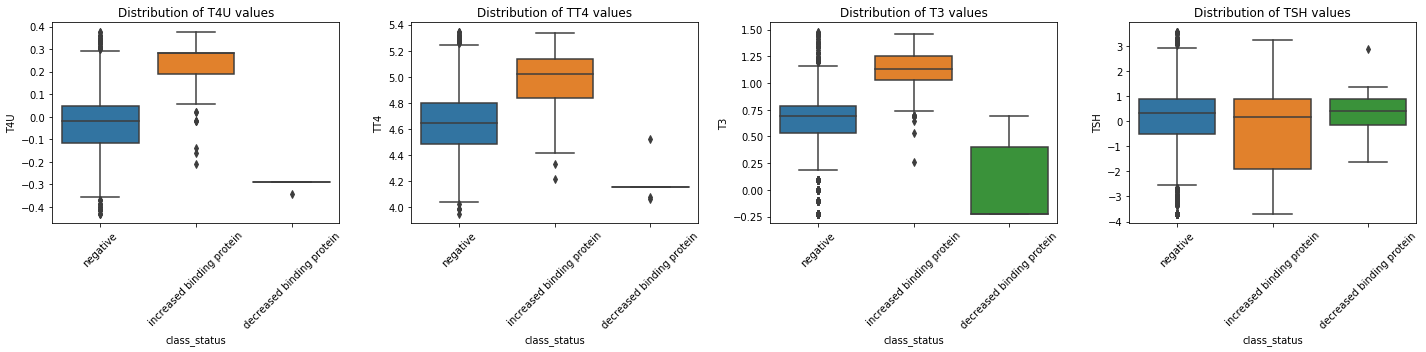

In [187]:
plt.rcParams['figure.figsize'] = (20, 5)

plt.subplot(1, 4, 1)
sns.boxplot('class_status','T4U', data=df_train)
plt.title('Distribution of T4U values')
plt.xticks(rotation=45)

plt.subplot(1, 4, 2)
sns.boxplot('class_status','TT4', data=df_train)
plt.title('Distribution of TT4 values')
plt.xticks(rotation=45)

plt.subplot(1, 4, 3)
sns.boxplot('class_status','T3', data=df_train)
plt.title('Distribution of T3 values')
plt.xticks(rotation=45)

plt.subplot(1, 4, 4)
sns.boxplot('class_status','TSH', data=df_train)
plt.title('Distribution of TSH values')
plt.xticks(rotation=45)

plt.tight_layout()

Those attributes have been identified to be useful for prediction.

We will create classifier, depending on manual chosen rules. However, classifier will choose boundary values automatically by fitting the data. Classifier is implemented as usual sklearn classifier, so *fit* and *predict* methods are available.

In [174]:
class ManualRulesClassifier():
    def __init__(self):
        pass
    
    def get_ranges(self, columns, label):
        self.columns_class_ranges = {}
        for column in columns:
            class_ranges = []
            for class_ in self.unique_class_status:
                Q1 = self.train[label == class_][column].quantile(.25)
                Q2 = self.train[label == class_][column].quantile(.50)
                Q3 = self.train[label == class_][column].quantile(.75)
                class_ranges.append([Q1,Q2,Q3])
            self.columns_class_ranges[column] = class_ranges
   
    def get_prediction(self, row):
        scores = [0,0,0]
        for key, value in self.columns_class_ranges.items():
            value = row[key]
            for i in range(0,3):
                Q1 = self.columns_class_ranges[key][i][0]
                Q2 = self.columns_class_ranges[key][i][1]
                Q3 = self.columns_class_ranges[key][i][2]
                
                lower_boundary = Q1 - (Q3 - Q1) * 1.5
                upper_boundary = Q3 + (Q3 - Q1) * 1.5

                if (value >= Q1 and value <= Q3):
                    scores[i] += 2
                elif ((value < Q1 and value >= lower_boundary) or (value > Q3 and value <= upper_boundary)):
                    scores[i] += 1
                elif (value == Q2):
                    scores[i] += 3
                
        max_ = 0
        max_counter = 0
        index = 0
        
        for i in range(0,3):
            if (scores[i] > max_):
                max_ = scores[i]
                max_counter = 0
                index = i
            elif (scores[i] == max_):
                max_counter += 1
        
        return self.unique_class_status[index]
    
    def fit(self, df_train, y_train):
        self.train = df_train
        self.unique_class_status = y_train.unique()
        self.get_ranges(['T4U', 'T3', 'TT4', 'TSH'], y_train)

    def predict(self, df_test):
        predictions = []
        for index, row in df_test.iterrows():
            predictions.append(self.get_prediction(row))
        return predictions

Now, let's create classifier, fit the data and predict values:

In [175]:
manual_rules_clf = ManualRulesClassifier()

In [176]:
manual_rules_clf.fit(X_train, y_train)
y_pred = manual_rules_clf.predict(X_test)

Records are predicted, check the accuracy score:

In [177]:
accuracy_score(y_test, y_pred)

0.87242798353909468

Accuracy score is not bad in this case, but because of heavily unbalanced data is not representative.

In [178]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.11      0.80      0.20         5
increased binding protein       0.16      0.64      0.26        25
                 negative       0.99      0.88      0.93       942

                micro avg       0.87      0.87      0.87       972
                macro avg       0.42      0.77      0.46       972
             weighted avg       0.96      0.87      0.91       972



@TODO popis vysledkov, napisat tiez preco sme pridali TSH, ze mozno az tak nepomohol ale hodi sa pre decreased, s nim lepsie skore

### DecisionTree

As decision tree is based on finding rules, it seems to be proper choice to compare with our manual rules based classifier.

In [18]:
dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced')

In [19]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
y_pred = dt.predict(X_test)

In [21]:
accuracy_score(y_test, y_pred)

0.95781893004115226

In [22]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.67      0.80      0.73         5
increased binding protein       0.37      0.76      0.50        25
                 negative       0.99      0.96      0.98       942

                micro avg       0.96      0.96      0.96       972
                macro avg       0.68      0.84      0.74       972
             weighted avg       0.97      0.96      0.96       972



In [23]:
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

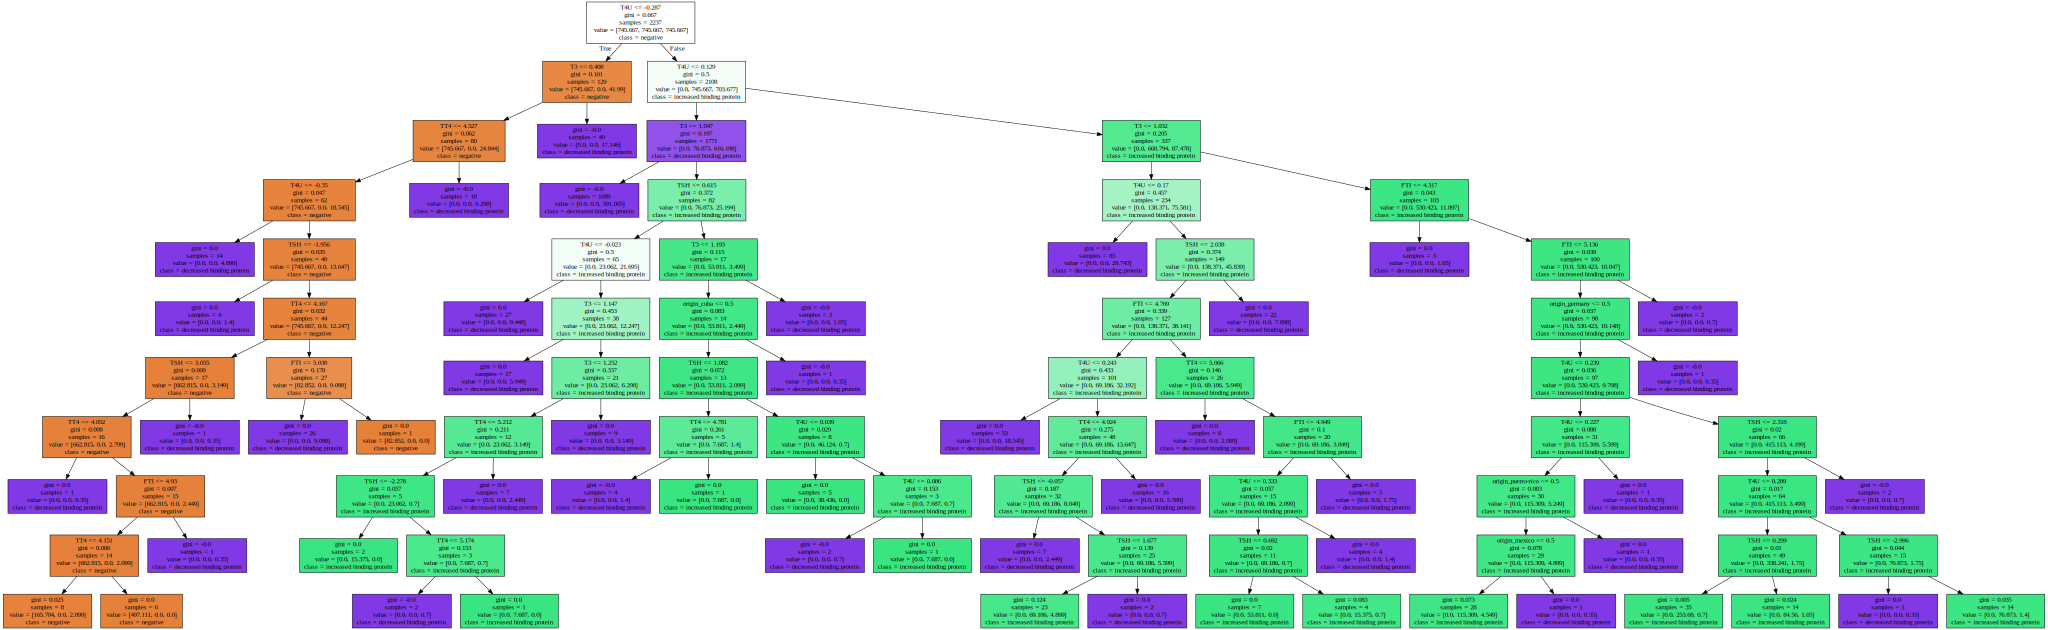

In [24]:
graph = Source(tree.export_graphviz(dt, out_file=None
   , feature_names=X_train.columns, class_names=y_train.unique() 
   , filled = True))

display(SVG(graph.pipe(format='svg')))

### Decision tree parameter tuning

In [25]:
decision_tree = DecisionTreeClassifier()

In [207]:
param_dist = {"max_depth": [x for x in range(1, 15)], "min_samples_leaf": [x for x in range(1, 6)], "max_features": [x for x in range(1, 20)], "criterion":["gini","entropy"]}

### Affect of max depth settings

In [192]:
scores_train_acc = []
scores_test_acc = []
scores_train_f1 = []
scores_test_f1 = []

for i in param_dist["max_depth"]:
    dt_t = DecisionTreeClassifier(max_depth = i)
    dt_t.fit(X_train, y_train)
#     scores_train.append(cross_val_score(dt_t, X_train, y_train, cv=10, scoring='f1_macro'))
#     scores_test.append(cross_val_score(dt_t, X_test, y_test, cv=10, scoring='f1_macro'))
    train_pred = dt_t.predict(X_train)
    test_pred = dt_t.predict(X_test)
    
    scores_train_f1.append(f1_score(y_train, train_pred , average='macro'))
    scores_test_f1.append(f1_score(y_test, test_pred , average='macro'))

    scores_train_acc.append(accuracy_score(y_train, train_pred))
    scores_test_acc.append(accuracy_score(y_test, test_pred))

In [193]:
# scores_train = [sum(x) / len(x) for x in scores_train]
# scores_test = [sum(x) / len(x) for x in scores_test]

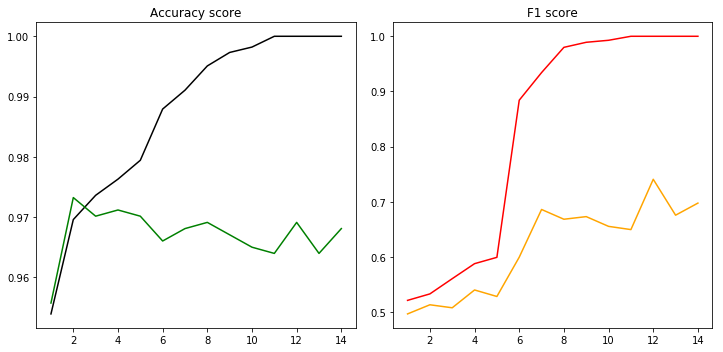

In [195]:
plt.rcParams['figure.figsize'] = (20, 5)

plt.subplot(1, 4, 1)
plt.plot(param_dist['max_depth'],scores_train_acc, color='black')
plt.plot(param_dist['max_depth'],scores_test_acc, color='green')
plt.title('Accuracy score')

plt.subplot(1, 4, 2)
plt.plot(param_dist['max_depth'],scores_train_f1, color='red')
plt.plot(param_dist['max_depth'],scores_test_f1, color='orange')
plt.title('F1 score')

plt.tight_layout()

In [204]:
scores_train_acc = []
scores_test_acc = []
scores_train_f1 = []
scores_test_f1 = []

for i in param_dist["min_samples_leaf"]:
    dt_t = DecisionTreeClassifier(min_samples_leaf = i)
    dt_t.fit(X_train, y_train)
#     scores_train.append(cross_val_score(dt_t, X_train, y_train, cv=10, scoring='f1_macro'))
#     scores_test.append(cross_val_score(dt_t, X_test, y_test, cv=10, scoring='f1_macro'))
    train_pred = dt_t.predict(X_train)
    test_pred = dt_t.predict(X_test)
    
    scores_train_f1.append(f1_score(y_train, train_pred , average='macro'))
    scores_test_f1.append(f1_score(y_test, test_pred , average='macro'))

    scores_train_acc.append(accuracy_score(y_train, train_pred))
    scores_test_acc.append(accuracy_score(y_test, test_pred))

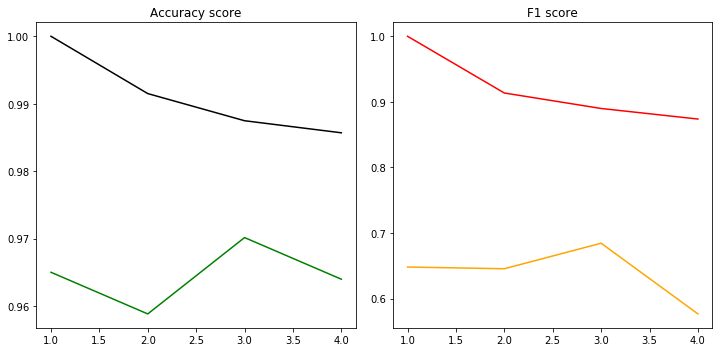

In [205]:
plt.rcParams['figure.figsize'] = (20, 5)

plt.subplot(1, 4, 1)
plt.plot(param_dist['min_samples_leaf'],scores_train_acc, color='black')
plt.plot(param_dist['min_samples_leaf'],scores_test_acc, color='green')
plt.title('Accuracy score')

plt.subplot(1, 4, 2)
plt.plot(param_dist['min_samples_leaf'],scores_train_f1, color='red')
plt.plot(param_dist['min_samples_leaf'],scores_test_f1, color='orange')
plt.title('F1 score')

plt.tight_layout()

In [0]:
scores_train_acc = []
scores_test_acc = []
scores_train_f1 = []
scores_test_f1 = []

for i in param_dist["max_features"]:
    dt_t = DecisionTreeClassifier(min_samples_leaf = i)
    dt_t.fit(X_train, y_train)
#     scores_train.append(cross_val_score(dt_t, X_train, y_train, cv=10, scoring='f1_macro'))
#     scores_test.append(cross_val_score(dt_t, X_test, y_test, cv=10, scoring='f1_macro'))
    train_pred = dt_t.predict(X_train)
    test_pred = dt_t.predict(X_test)
    
    scores_train_f1.append(f1_score(y_train, train_pred , average='macro'))
    scores_test_f1.append(f1_score(y_test, test_pred , average='macro'))

    scores_train_acc.append(accuracy_score(y_train, train_pred))
    scores_test_acc.append(accuracy_score(y_test, test_pred))

### RandomForest

In [25]:
rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=0, class_weight='balanced')

In [26]:
X_train.head()

,T4U,TT4,TSH,T3,FTI,sex_F,sex_M,pregnant_False,pregnant_True,origin_cambodia,...,origin_outlying-us(guam-usvi-etc),origin_peru,origin_philippines,origin_poland,origin_puerto-rico,origin_south,origin_taiwan,origin_thailand,origin_united-states,origin_vietnam
0,-0.211386,4.418841,0.993252,0.788457,4.625681,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.061875,4.787492,1.131402,0.405465,4.844187,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.040822,4.727388,0.262364,0.832909,4.770685,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.019803,5.209486,-3.352407,0.741937,5.187386,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.072571,4.976734,-3.688879,1.014890,5.043425,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [28]:
y_pred = rf.predict(X_test)

In [29]:
accuracy_score(y_test, y_pred)

0.97427983539094654

In [30]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.00      0.00      0.00         5
increased binding protein       0.60      0.60      0.60        25
                 negative       0.98      0.99      0.99       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.53      0.53      0.53       972
             weighted avg       0.97      0.97      0.97       972



/ext/sage/sage-8.4_1804/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/ext/sage/sage-8.4_1804/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/ext/sage/sage-8.4_1804/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 ascending=False)

In [39]:
feature_importances

,importance
T4U,3.237622e-01
T3,2.566458e-01
TT4,2.081217e-01
FTI,8.356671e-02
TSH,6.382078e-02
sex_F,1.331085e-02
pregnant_False,1.134707e-02
sex_M,1.121780e-02
pregnant_True,1.120091e-02
origin_nicaragua,7.660023e-03


### Hyperparameter tuning

In [65]:
rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=0, class_weight='balanced')

tuned_clf = RandomizedSearchCV(rf, param_distributions={'n_estimators': [x for x in range(10, 500, 20)], 'max_depth': [x for x in range(8, 20, 2)]}, n_iter=10, scoring='f1_macro')

In [66]:
tuned_clf.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490], 'max_depth': [8, 10, 12, 14, 16, 18]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_macro', verbose=0)

In [60]:
tuned_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [61]:
y_pred = tuned_clf.predict(X_test)

In [63]:
accuracy_score(y_test, y_pred)

0.97222222222222221

In [64]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.00      0.00      0.00         5
increased binding protein       0.57      0.52      0.54        25
                 negative       0.98      0.99      0.99       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.52      0.50      0.51       972
             weighted avg       0.97      0.97      0.97       972



## Different filling methods comparison

In [40]:
ppl_fill = Pipeline([
                # Data repairing
                # ======================
                # unify boolean values
                ('unify_boolean', BooleanUnifier(['query hyperthyroid', 'T4U measured', 'on thyroxine', 'FTI measured', 'lithium', 'TT4 measured',
                                                  'query hypothyroid', 'query on thyroxine', 'tumor', 'T3 measured', 'sick', 'thyroid surgery', 
                                                  'I131 treatment', 'goitre', 'TSH measured', 'on antithyroid medication', 'psych', 'TBG measured',
                                                  'pregnant', 'hypopituitary'])),

                # unify date format
                ('date_unifier', DateFormatUnifier('date_of_birth')),

                # drop column
                ('drop_TBG_measured', DropColumn('TBG measured')),
                ('drop_TBG', DropColumn('TBG')),

                # measured columns fix
                ('fix_measured_values',MeasuredValuesFixer(['T4U', 'FTI', 'TT4', 'TT4','TSH','T3'])),

                # expand column
                ('expand_personal_info', ColumnExpander()),

                # unify nan values
                ('nan_unify_FTI', NanUnifier(['FTI', 'sex', 'origin', 'occupation'])),

                # transform data type
                ('column_to_number_FTI', ColumnToNumber('FTI')),

                # merge and remove duplicates
                ('rm_duplicates', MergeRemoveDuplicates()),
                
                # ======================

                # Data normalization
                # ======================
                ('norm_numerical', Normalizer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Outliers replacement
                # ======================
                ('reout_numerical', OutliersReplacer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age', 'education-num'])),
                # ======================

                # Filling numerical values with median
                # ======================
                ('fill_med', NumMedianFiller(['T4U', 'TT4', 'T3', 'TSH', 'FTI', 'age', 'education-num',
                                              'fnlwgt', 'capital-loss', 'capital-gain', 'hours-per-week'])),
                # ======================

                # Filling categorical with most frequent value
                # ======================
                ('fill_mf', CategoricalMostFrequentFiller(['sex', 'pregnant', 'tumor', 'occupation', 'origin',
                                                            'query hypothyroid', 'query hyperthyroid', 'on thyroxine',
                                                            'sick', 'thyroid surgery', 'workclass',
                                                            'I131 treatment', 'hypopituitary', 'query on thyroxine',
                                                            'on antithyroid medication', 'referral source', 'psych',
                                                            'date_of_birth', 'study', 'status1', 'status2'
                ]))
              ])

In [41]:
df_train = ppl_fill.fit_transform(df_train_raw)
df_valid = ppl_fill.transform(df_valid_raw)

df_train = ppl_class_unifier.fit_transform(df_train)
df_valid = ppl_class_unifier.transform(df_valid)

In [43]:
X_train = ppl_select_encode.fit_transform(df_train)
X_test = ppl_select_encode.transform(df_valid)

In [44]:
dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced')

In [45]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [46]:
y_pred = dt.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred)

0.95987654320987659

In [48]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

decreased binding protein       0.60      0.60      0.60         5
increased binding protein       0.41      0.88      0.56        25
                 negative       0.99      0.96      0.98       942

                micro avg       0.96      0.96      0.96       972
                macro avg       0.67      0.81      0.71       972
             weighted avg       0.98      0.96      0.97       972



## Predictions on test dataset

## TO-DO

Pri dátovej analýze nemusí byť naším cieľom získať len znalosti obsiahnuté v aktuálnych
dátach, ale aj natrénovať model, ktorý bude schopný robiť rozumné predikcie pre nové
pozorovania (v našom prípade pre nových pacientov). Na to sa využívajú techniky
strojového učenia. V tomto projekte sa zameriame na rozhodovacie stromy vzhľadom na ich
jednoduchú interpretovateľnosť.

V tejto fáze dostanete nový dataset, na ktorom oddemonštrujete znovupoužiteľnosť vami
realizovaného predspracovania. Vami natrénované klasifikátory budú porovnané medzi
sebou; uvidíte tak, ako dobre ste sa umiestnili v rámci vášho cvičenia, resp. celého
predmetu.

V poslednej fáze sa od vás očakáva:

* **Predspracovanie nového datasetu vami realizovaným postupom**
predspracovania. Spustite postup predspracovania realizovaný v predchádzajúcom
kroku nad novým datasetom. Nový dataset bude mať rovnakú štruktúru ako váš
pôvodný, nebudú sa v ňom však možno nachádzať niektoré problémy (nové vám
nepribudnú). Ak si spustenie predspracovania vyžiada zmeny v kóde, opíšte ich.
* **Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu.**
Vyskúšajte jednoduché pravidlá zahŕňajúce jeden atribút, ale aj komplikovanejšie
zahŕňajúce viacero atribútov (ich kombinácie). Pravidlá by v tomto kroku mali byť
vytvorené manuálne na základe pozorovaných závislostí v dátach. Pravidlá
(manuálne vytvorené klasifikátory) vyhodnoťte pomocou metrík správnosť (angl.
accuracy ), presnosť (angl. precision ) a úplnosť (angl. recall ).
* **Natrénovanie klasifikátora s využitím rozhodovacích stromov.**
Využite algoritmus dostupný v knižnici scikit-learn ( CART) . Preskúmajte hyperparametre
tohto algoritmu a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali
preučenie. Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní
hyperparametrov algoritmu využite 10-násobnú krížovú validáciu na trénovacej
množine.
* **Vyhodnotenie natrénovaných klasifikátorov. Vizualizujte natrénované pravidlá.**
Porovnajte algoritmy navzájom, ako aj s vašimi manuálne vytvorenými pravidlami z
druhého kroku. Vyhodnoťte ich pomocou metrík správnosť (angl. accuracy ), presnosť
(angl. precision ) a úplnosť (angl. recall ).
* **Vyhodnotenie vplyvu zvolenej stratégie riešenia chýbajúcich hodnôt na správnosť klasifikácie.**
Zistite, či použitie zvolených stratégií riešenia chýbajúcich
hodnôt vplýva na správnosť (angl. accuracy ) klasifikácie. Ktorá stratégia sa ukázala
ako vhodnejšia pre daný problém?

**Celkové hodnotenie za 3. fázu (12b) je rozdelené nasledovne:**
* Realizácia predspracovania nad novým datasetom a opis prípadných zmien - 2b / done, este opisy
* Návrh a overenie manuálne vytvorených pravidiel - 2b
* Porovnanie stratégie riešenia chýbajúcich hodnôt - 2b
* Natrénovanie a otestovanie klasifikátora (klasifikátorov) - 2b
* Optimalizácia hyperparametrov - 2b
* Celkový dojem - 2b



### Tasky:
* jendoduche pravidla manualne a vyhodnotit, popisat
* popisat vysledky manualneho classifiera kombinovaneho
* porovnanie klassifikatorov medzi sebou ako Conclusion and comparison sekcia v Classification
* vizualizacia pravidiel decision tree
* porovnanie vysledkov oversamplingu a beznych klasifikatorov
* porovnat doplnanie hodnot s beznymi klasifikatormi zhora